In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
merged_df = pd.read_csv('merged_df.csv')
merged_df.head()

,ID,Gender,Car,Property,Children,Income,Income status,Education,Marital,Housing,...,Job,Family,0,1,2,3,4,5,C,X
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,1,1,0,0,0,0,13,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,NaN,2,1,1,0,0,0,0,12,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,Security staff,2,7,0,0,0,0,0,7,16
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,2,0,0,0,0,0,0,3
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,0,0,0,0,0,0,0,5


In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               36457 non-null  int64  
 1   Gender           36457 non-null  object 
 2   Car              36457 non-null  object 
 3   Property         36457 non-null  object 
 4   Children         36457 non-null  int64  
 5   Income           36457 non-null  float64
 6   Income status    36457 non-null  object 
 7   Education        36457 non-null  object 
 8   Marital          36457 non-null  object 
 9   Housing          36457 non-null  object 
 10  Day since birth  36457 non-null  int64  
 11  Days employed    36457 non-null  int64  
 12  Mobile           36457 non-null  int64  
 13  Work phone       36457 non-null  int64  
 14  Phone            36457 non-null  int64  
 15  Email            36457 non-null  int64  
 16  Job              25134 non-null  object 
 17  Family      

In [6]:
merged_df.Mobile.unique()

array([1], dtype=int64)

We can remove the ID and mobile columns because the mobile column has only one value, which is unnecessary repetition. Similarly, the ID isn't needed for our purpose. 

In [7]:
merged_df = merged_df.drop(['ID', 'Mobile'], axis = 1)

# Exploratory data analysis

<br>
Instead of directly analyzing the overdue status, we might prefer to pinpoint clients with a high likelihood of bad debt. We could categorize those with only status 0 in their history as having a low chance of bad debt since these overdues are quite common. Anyone with a status of 1 or higher in their credit history can be classified as having a high chance. <br><br>

In [8]:
import math
# Summing the column from 1 to 5
merged_df['Bad debt chance'] = merged_df.iloc[:,17:-2].sum(axis=1, min_count=1)
# Low if the sum is 0, else high
merged_df['Bad debt chance'] = merged_df['Bad debt chance'].apply(lambda x: 'low' if (x == 0) else 'high')

merged_df['Bad debt chance'].value_counts()

Bad debt chance
low     32166
high     4291
Name: count, dtype: int64

In [9]:
# Drop the status columns since we summarized it with bad debt chance
merged_df = merged_df.drop(merged_df.iloc[:,16:-1].columns, axis = 1)

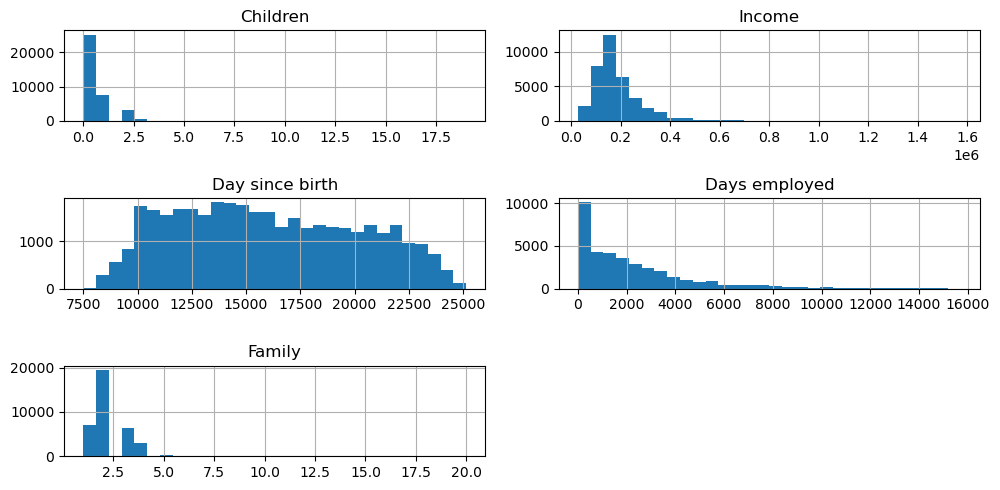

In [10]:
# Histogram with numerical features
merged_df.drop(['Work phone', 'Phone', 'Email'], axis = 1).hist(bins=30, figsize=(10, 5))
plt.tight_layout()

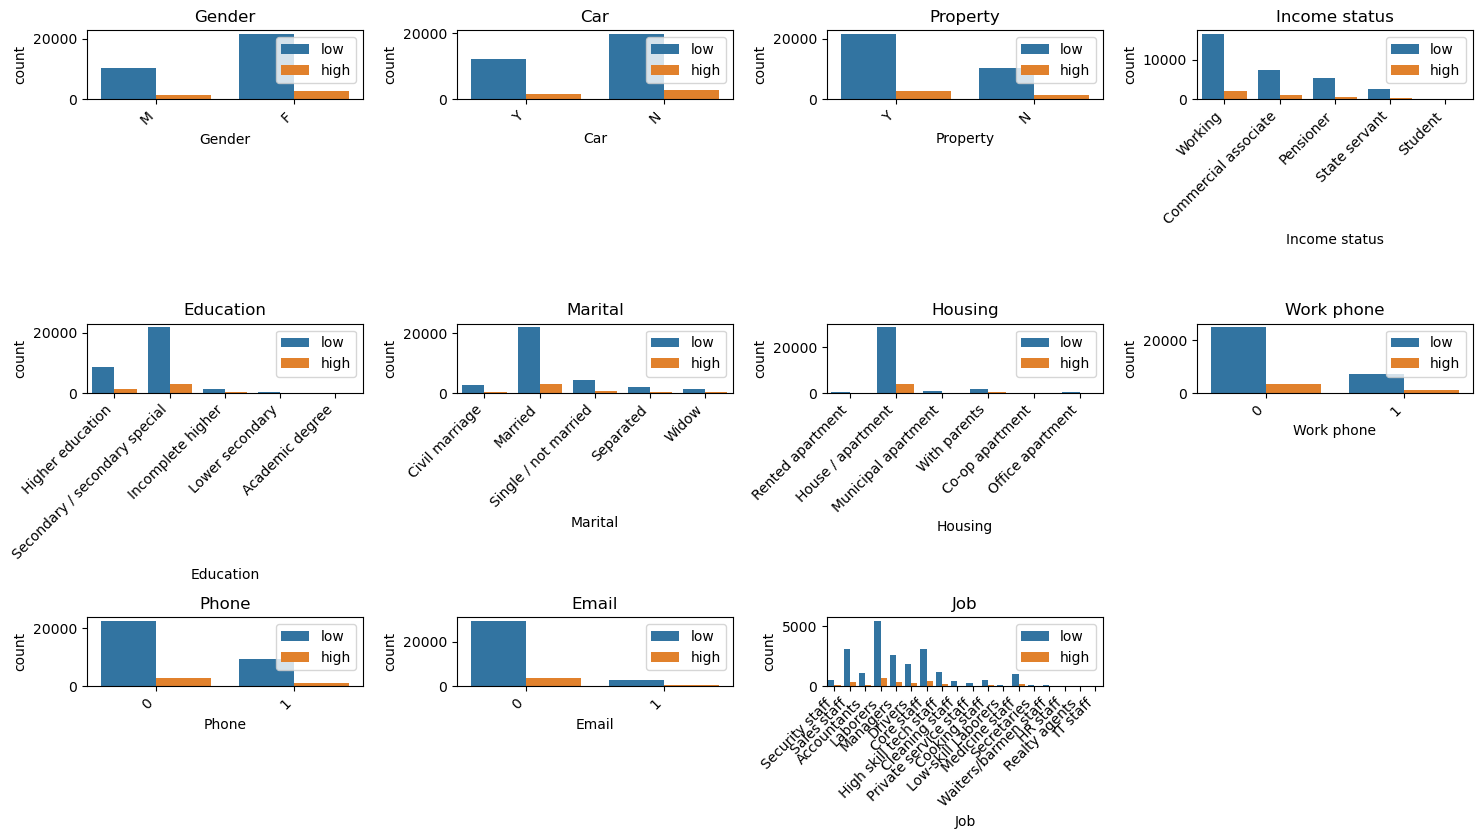

In [11]:
# Countplot with categorical features
features = ['Gender', 'Car', 'Property', 'Income status', 'Education', 'Marital', 'Housing', 'Work phone', 'Phone', 'Email', 'Job']
plt.figure(figsize=(15, 10))

for feature in features:
    plt.subplot(4, 4, features.index(feature) + 1)
    sns.countplot(data=merged_df, x=feature, hue = 'Bad debt chance', hue_order=['low', 'high'])
    plt.xticks(rotation=45, ha='right')
    plt.title(feature)
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

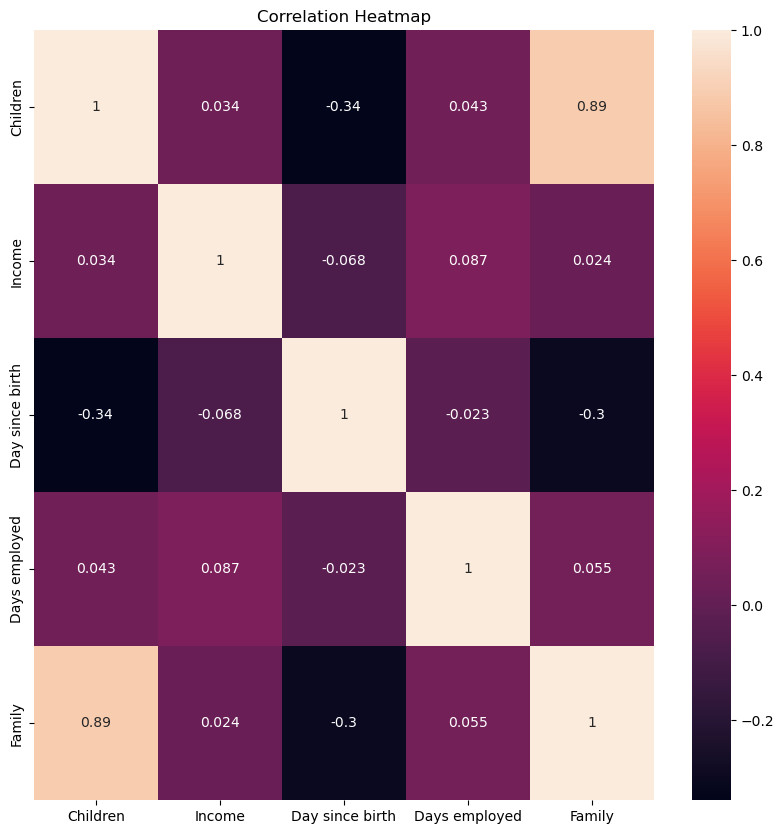

In [12]:
# Correlation heatmap with numerical features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
sns.heatmap(merged_df.select_dtypes(include =['float64', 'int64']).drop(['Email', 'Phone', 'Work phone'], axis = 1).corr(), annot = True)
plt.title('Correlation Heatmap')

<br>As observed, there's a high correlation between children and family, which aligns with our expectations. It might be beneficial to eliminate one of these columns during the data preprocessing stage. <br><br>

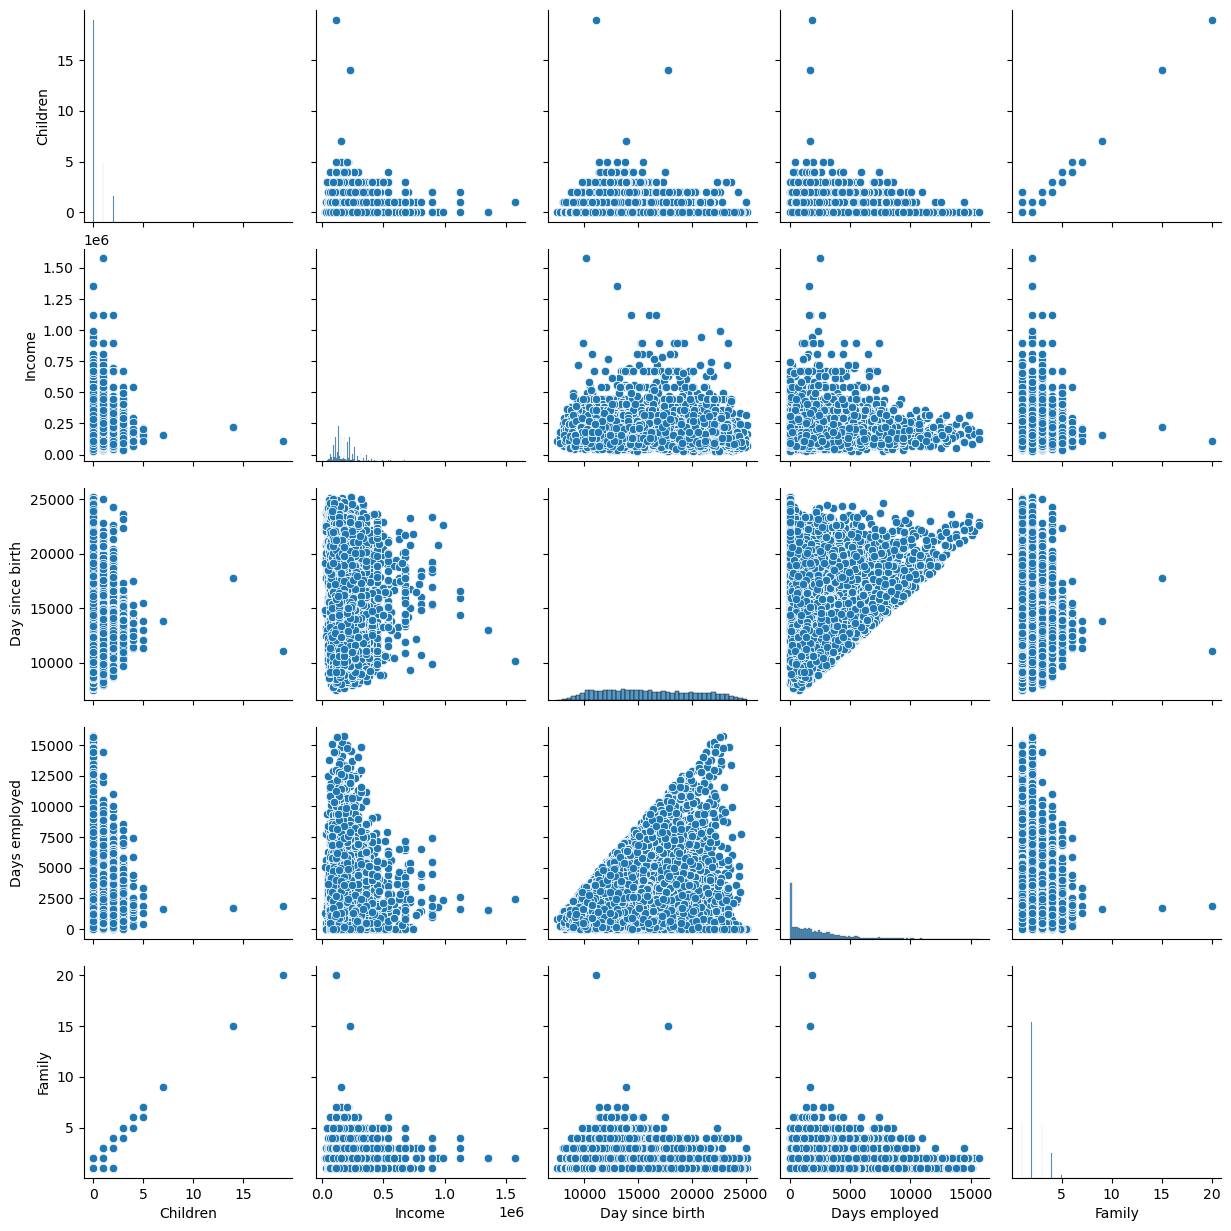

In [13]:
# Pairplot on numerical features
sns.pairplot(merged_df.select_dtypes(include =['float64', 'int64']).drop(['Email', 'Phone', 'Work phone'], axis = 1))

# Data Preprocessing

Hypothesis: credit status is heavily influenced by income, we could use a stratified sample of income as train and test class to ensure the distribution of income class remain consistent. 

In [14]:
# Engineering income category for stratified sample
def cat(x):
    if x <= 100000:
        return "low"
    elif x <= 300000:
        return 'medium'
    else:
        return 'high'
        
merged_df['Income_cat'] = merged_df['Income'].apply(cat)

merged_df['Income_cat'].value_counts()

Income_cat
medium    27542
low        5086
high       3829
Name: count, dtype: int64

In [15]:
# Defining stratified train and test set
from sklearn.model_selection import train_test_split

X = merged_df.drop(['Family', 'Bad debt chance'], axis = 1)
y = merged_df['Bad debt chance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=X['Income_cat'])

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25519 entries, 34239 to 24918
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           25519 non-null  object 
 1   Car              25519 non-null  object 
 2   Property         25519 non-null  object 
 3   Children         25519 non-null  int64  
 4   Income           25519 non-null  float64
 5   Income status    25519 non-null  object 
 6   Education        25519 non-null  object 
 7   Marital          25519 non-null  object 
 8   Housing          25519 non-null  object 
 9   Day since birth  25519 non-null  int64  
 10  Days employed    25519 non-null  int64  
 11  Work phone       25519 non-null  int64  
 12  Phone            25519 non-null  int64  
 13  Email            25519 non-null  int64  
 14  Job              17550 non-null  object 
 15  Income_cat       25519 non-null  object 
dtypes: float64(1), int64(6), object(9)
memory usage: 3.3+ MB


<br>
Next, we'll construct a data pipeline to preprocess both the training and testing sets. This step is crucial before proceeding to classification. For numerical features, we'll utilize a simple imputer to replace missing values with the mean and scale them using StandardScaler. Note that the family column has been excluded due to its overlap with children. Additionally, we'll perform one-hot encoding for categorical variables and combine them using FeatureUnion. <br><br>

In [17]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

cat_attribs = X_train.drop(['Children', 'Income', 'Day since birth', 'Days employed', 'Income_cat'], axis = 1).columns
num_attribs = X_train.iloc[:,[3, 4, 9, 10]].columns

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder())
])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_pipeline),
    ('num_pipeline', num_pipeline),
])

In [18]:
# Transform the training and testing data sets
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

# Classification

In [23]:
# Performing logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression(solver = 'liblinear', C=1e9, class_weight = {'low':2,'high':8},random_state = 0)
model.fit(X_train_prepared, y_train)

y_pred = model.predict(X_train_prepared)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        high       0.25      0.01      0.02      2981
         low       0.88      1.00      0.94     22538

    accuracy                           0.88     25519
   macro avg       0.57      0.50      0.48     25519
weighted avg       0.81      0.88      0.83     25519



<br>
While logistic regression demonstrates good accuracy, accurately classifying clients with a high chance of bad debt is paramount for a bank. Despite adjusting the weights, the recall for the high-risk category remains only at 0.01 &#x1F631; Below is the formula for recall. <br><br>

<img src="recall.png" width=600 height=600 />


Undersampling is a method in machine learning where we reduce the number of examples in the larger group to make it more equal with the smaller group. This helps the model learn better from both types of examples. For instance, in classifying clients with a high chance of bad debt, we might reduce the number of clients with a low chance of bad debt so that the model learns equally from both types of clients.

In [24]:
# UnderSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1) 
X_res, y_res = rus.fit_resample(X_train_prepared, y_train)

In [25]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(solver = 'liblinear', random_state = 0)
model.fit(X_res, y_res)
y_pred = model.predict(X_train_prepared)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        high       0.13      0.52      0.21      2981
         low       0.90      0.56      0.69     22538

    accuracy                           0.55     25519
   macro avg       0.52      0.54      0.45     25519
weighted avg       0.81      0.55      0.63     25519



Now that we've improved the recall, let's explore a few more machine learning algorithms before further optimization.

In [26]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(X_res, y_res)

y_pred = rf.predict(X_train_prepared)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        high       0.28      0.93      0.44      2981
         low       0.99      0.69      0.81     22538

    accuracy                           0.72     25519
   macro avg       0.64      0.81      0.62     25519
weighted avg       0.90      0.72      0.77     25519



In [27]:
# K-neighbors
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_res, y_res)

y_pred = knn_model.predict(X_train_prepared)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        high       0.17      1.00      0.30      2981
         low       1.00      0.37      0.54     22538

    accuracy                           0.45     25519
   macro avg       0.59      0.69      0.42     25519
weighted avg       0.90      0.45      0.51     25519




Despite the K-nearest neighbors classifier having a lower overall accuracy compared to random forests, it achieves a perfect score for the recall of clients with a high chance of bad debt. Given that this is the crucial metric for our use case, we should prioritize it. Additionally, there are methods available to enhance the accuracy of the algorithm.

We can optimize the algorithm using grid search. Grid search refers to trying different combinations of hyperparamters for your model to see which one works best. It tests out various options systematically to find the optimal configuration for your problem.

In [28]:
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(1, 5), 'p':[1, 2]}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_res, y_res)

y_pred = gridsearch.predict(X_train_prepared)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        high       0.24      1.00      0.39      2981
         low       1.00      0.59      0.74     22538

    accuracy                           0.64     25519
   macro avg       0.62      0.79      0.57     25519
weighted avg       0.91      0.64      0.70     25519



We managed to maintain the perfect recall for the model while also enhancing its accuracy through grid search. Now lets see how the algorithm performed on the test set.

In [31]:
y_pred = gridsearch.predict(X_test_prepared)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.19      0.77      0.30      1310
         low       0.95      0.55      0.70      9628

    accuracy                           0.58     10938
   macro avg       0.57      0.66      0.50     10938
weighted avg       0.86      0.58      0.65     10938



While the performance on the testing set isn't as strong as on the training set, this outcome was anticipated. Achieving a recall of 0.77 and an overall accuracy of 0.58 is actually quite respectable, especially considering the imbalanced nature of the dataset. We can visualize the predictions using a confusion matrix.

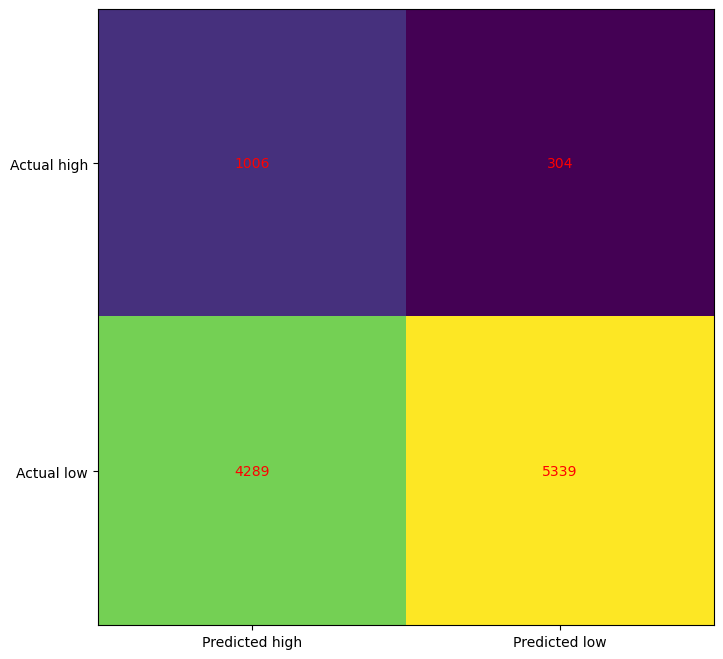

In [34]:
fig, ax = plt.subplots(figsize = (8, 8))

cm = confusion_matrix(y_test, y_pred)
ax.imshow(cm)

ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted high', 'Predicted low'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual high', 'Actual low'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

We have correctly classified 1006 out of 1310 clients with high bad debt chance. &#x1F44D;
